In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import model
from model import ProposalLayer, Dataset
from config import Config
import tensorflow as tf
import keras 
import keras.layers as KL
import keras.models as KM

config = Config()
dataset = model.Dataset(config=config, 
                        path=r'/home/yang/Downloads/COCO-dataset',
                        subset='val2017')

Using TensorFlow backend.


loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
num_of_classes: 81
Number of images: 14631
Number of classes: 81


In [2]:
generator = dataset.data_generator()
inputs, outputs = next(generator)

batch_image, \
batch_anchors_match, batch_anchors_delta_bbox,\
batch_mrcnn_classes, batch_mrcnn_bboxes, batch_mrcnn_masks = inputs

print('\n',
    'batch_image.shape: {}\n'.format(batch_image.shape), 
    'batch_anchors_match.shape: {}\n'.format(batch_anchors_match.shape), 
    'batch_anchors_delta_bbox.shape: {}\n'.format(batch_anchors_delta_bbox.shape),
    'batch_mrcnn_classes.shape: {}\n'.format(batch_mrcnn_classes.shape),
    'batch_mrcnn_bboxes.shape: {}\n'.format(batch_mrcnn_bboxes.shape),
    'batch_mrcnn_masks.shape: {}\n'.format(batch_mrcnn_masks.shape))

Feature map size: [256, 256], number of anchors: 49152
Feature map size: [128, 128], number of anchors: 12288
Feature map size: [64, 64], number of anchors: 3072
Feature map size: [32, 32], number of anchors: 768
Feature map size: [16, 16], number of anchors: 192
Total number of anchors:      65472


/home/yang/.conda/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/yang/.conda/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



 batch_image.shape: (1, 1024, 1024, 3)
 batch_anchors_match.shape: (1, 65472, 1)
 batch_anchors_delta_bbox.shape: (1, 256, 4)
 batch_mrcnn_classes.shape: (1, 100)
 batch_mrcnn_bboxes.shape: (1, 100, 4)
 batch_mrcnn_masks.shape: (1, 1024, 1024, 100)



In [3]:
# trim zeros
def get_pos(x):
    '''get positive boxes and trim zero ones'''
    sum = np.sum(np.abs(x), axis=-1)
    ids = np.where(sum != 0)
    
    return x[ids], ids

mrcnn_bboxes, ids = get_pos(batch_mrcnn_bboxes[-1])
mrcnn_classes = batch_mrcnn_classes[-1][ids]
mrcnn_masks = np.squeeze(batch_mrcnn_masks[-1][:,:,ids], axis=-2)

print('\n',
    'mrcnn_classes.shape: {}\n'.format(mrcnn_classes.shape),
    'mrcnn_bboxes.shape: {}\n'.format(mrcnn_bboxes.shape),
    'mrcnn_masks.shape: {}\n'.format(mrcnn_masks.shape))


 mrcnn_classes.shape: (30,)
 mrcnn_bboxes.shape: (30, 4)
 mrcnn_masks.shape: (1024, 1024, 30)



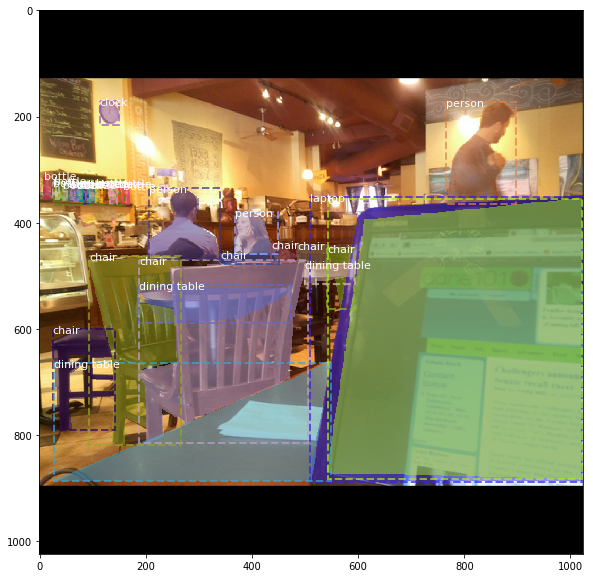

In [4]:
fig, ax = plt.subplots(1, figsize=(10, 10))
# ax.axis('off')

# set colors
num_instance = mrcnn_classes.shape[-1]
colors = dataset.random_colors(num_instance)

# apply mask
image = batch_image[-1]
for i in range(num_instance):
    image = dataset.apply_mask(image, 
                               mrcnn_masks[:,:,i], 
                               color=colors[i])
# showbbox:
for i in range(num_instance):
    x1, y1, w, h = mrcnn_bboxes[i]
    p = patches.Rectangle((x1, y1), w, h, 
                          linewidth=2,
                          alpha=0.7, 
                          linestyle="dashed",
                          edgecolor=colors[i], 
                          facecolor='none')                
    ax.add_patch(p)
    
    # show class
    ax.text(x1, y1+8, 
            dataset.map_id_to_class_name[mrcnn_classes[i]],
            color='w', size=11, backgroundcolor="none")

ax.imshow(image)
plt.show()